# Spaceship Titanic - Prediction of Accidental Transport
Xiaoyu Yang
<br>
Created on 10/15/23
<br>
Updated on 4/22/24

### Load data from kaggle.com (using kaggle API)

In [1]:
#!kaggle competitions download -c spaceship-titanic

In [2]:
#!mv spaceship-titanic.zip data/spaceship-titanic.zip

In [3]:
#from zipfile import ZipFile
#with ZipFile('data/spaceship-titanic.zip', 'r') as files:
#   files.extractall()

### Basic inspection of data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.mode.copy_on_write = True

In [5]:
df = pd.read_csv('../data/spaceship_titanic/train.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Feature EDA
The goals of feature EDA:
1. Create new features out of the existing info - e.g., using passenger ID, it is possible to identify family/group members and group size
2. Find the best strategy to impute values - e.g., some passengers didn't have home planet info. Would it be possible to deduce that info from group? Or use a KNN model to guess?
3. Find out the features that are mostly different between transported and non-transported passengers

##### Passenger ID -> Group Size
Observations:
- People traveling in group size 3-6 had higher rate of being transported
- People transported in group size 3-4 had wider age distribution

In [9]:
df['passenger_group'] = df['PassengerId'].str.split('_').apply(lambda x: x[0])
df['group_size'] = df.groupby('passenger_group').PassengerId.transform('count')

<Axes: xlabel='group_size', ylabel='Transported'>

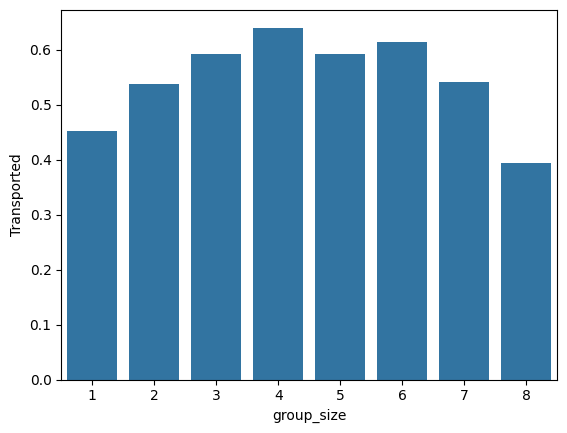

In [10]:
# plots to explore the target variable and group size
sns.barplot(data = df, x = 'group_size', y = 'Transported', errorbar = None)


<Axes: xlabel='group_size', ylabel='Age'>

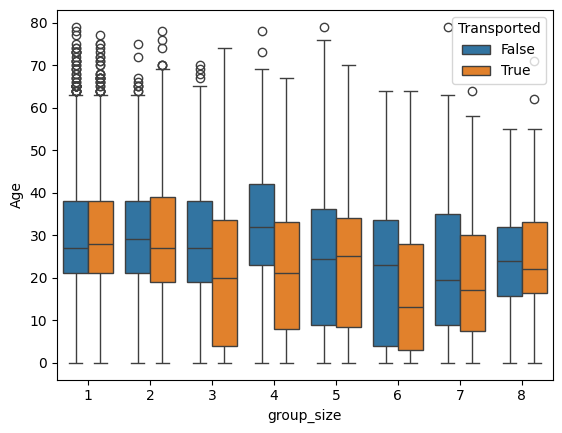

In [11]:
sns.boxplot(data = df, x = 'group_size', y = 'Age', hue = 'Transported')

##### Cabin -> Deck, Side, Cabin No.
Observation: people on Starboard had significantly higher possibility of being transported across all decks

In [12]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['cabin_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

<Axes: xlabel='deck', ylabel='Transported'>

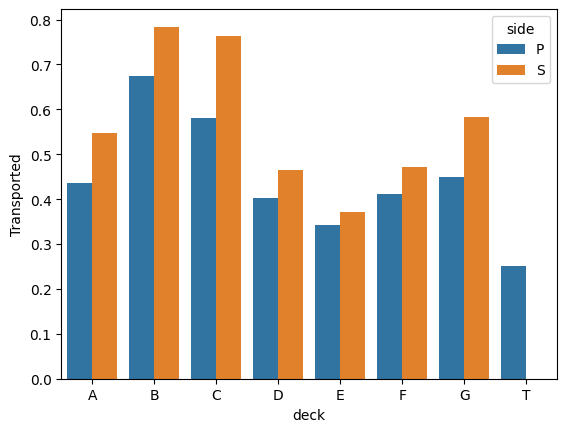

In [13]:
sns.barplot(data = df, x = 'deck', y = 'Transported', hue = 'side', errorbar = None, order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])

##### Home planet vs. Destination
Observation: people travelled from Europa had significantly higher possibility of being transported across destinations

<Axes: xlabel='Destination', ylabel='count'>

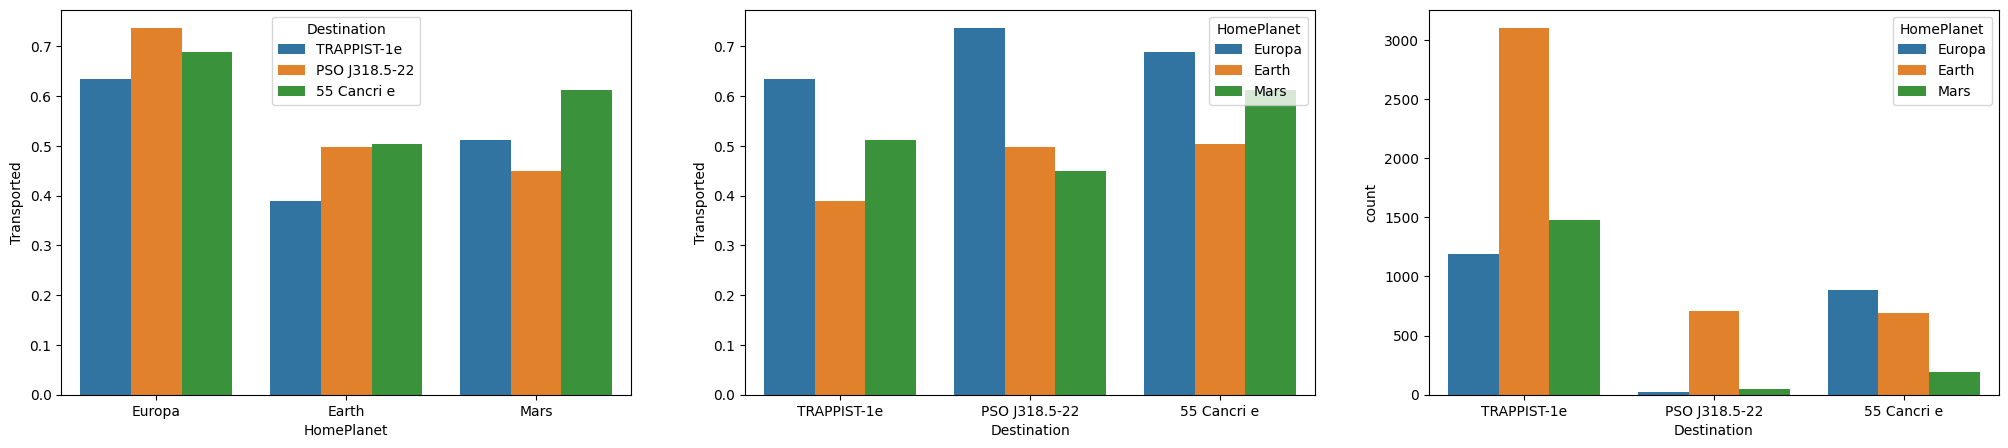

In [14]:
f, axs = plt.subplots(1, 3, figsize = (25, 5))
sns.barplot(data = df, x = 'HomePlanet', y = 'Transported', hue = 'Destination', errorbar = None, ax = axs[0])
sns.barplot(data = df, hue = 'HomePlanet', y = 'Transported', x = 'Destination', errorbar = None, ax = axs[1])
sns.countplot(data = df, x = 'Destination', hue = 'HomePlanet', ax = axs[2])


#### VIP, CryoSleep and other consumption onboard
Observations:
- People who chose to be put into suspended animation had significantly higher possibility of being transported
- People with lower total consumption of services had higher possibility of being transported

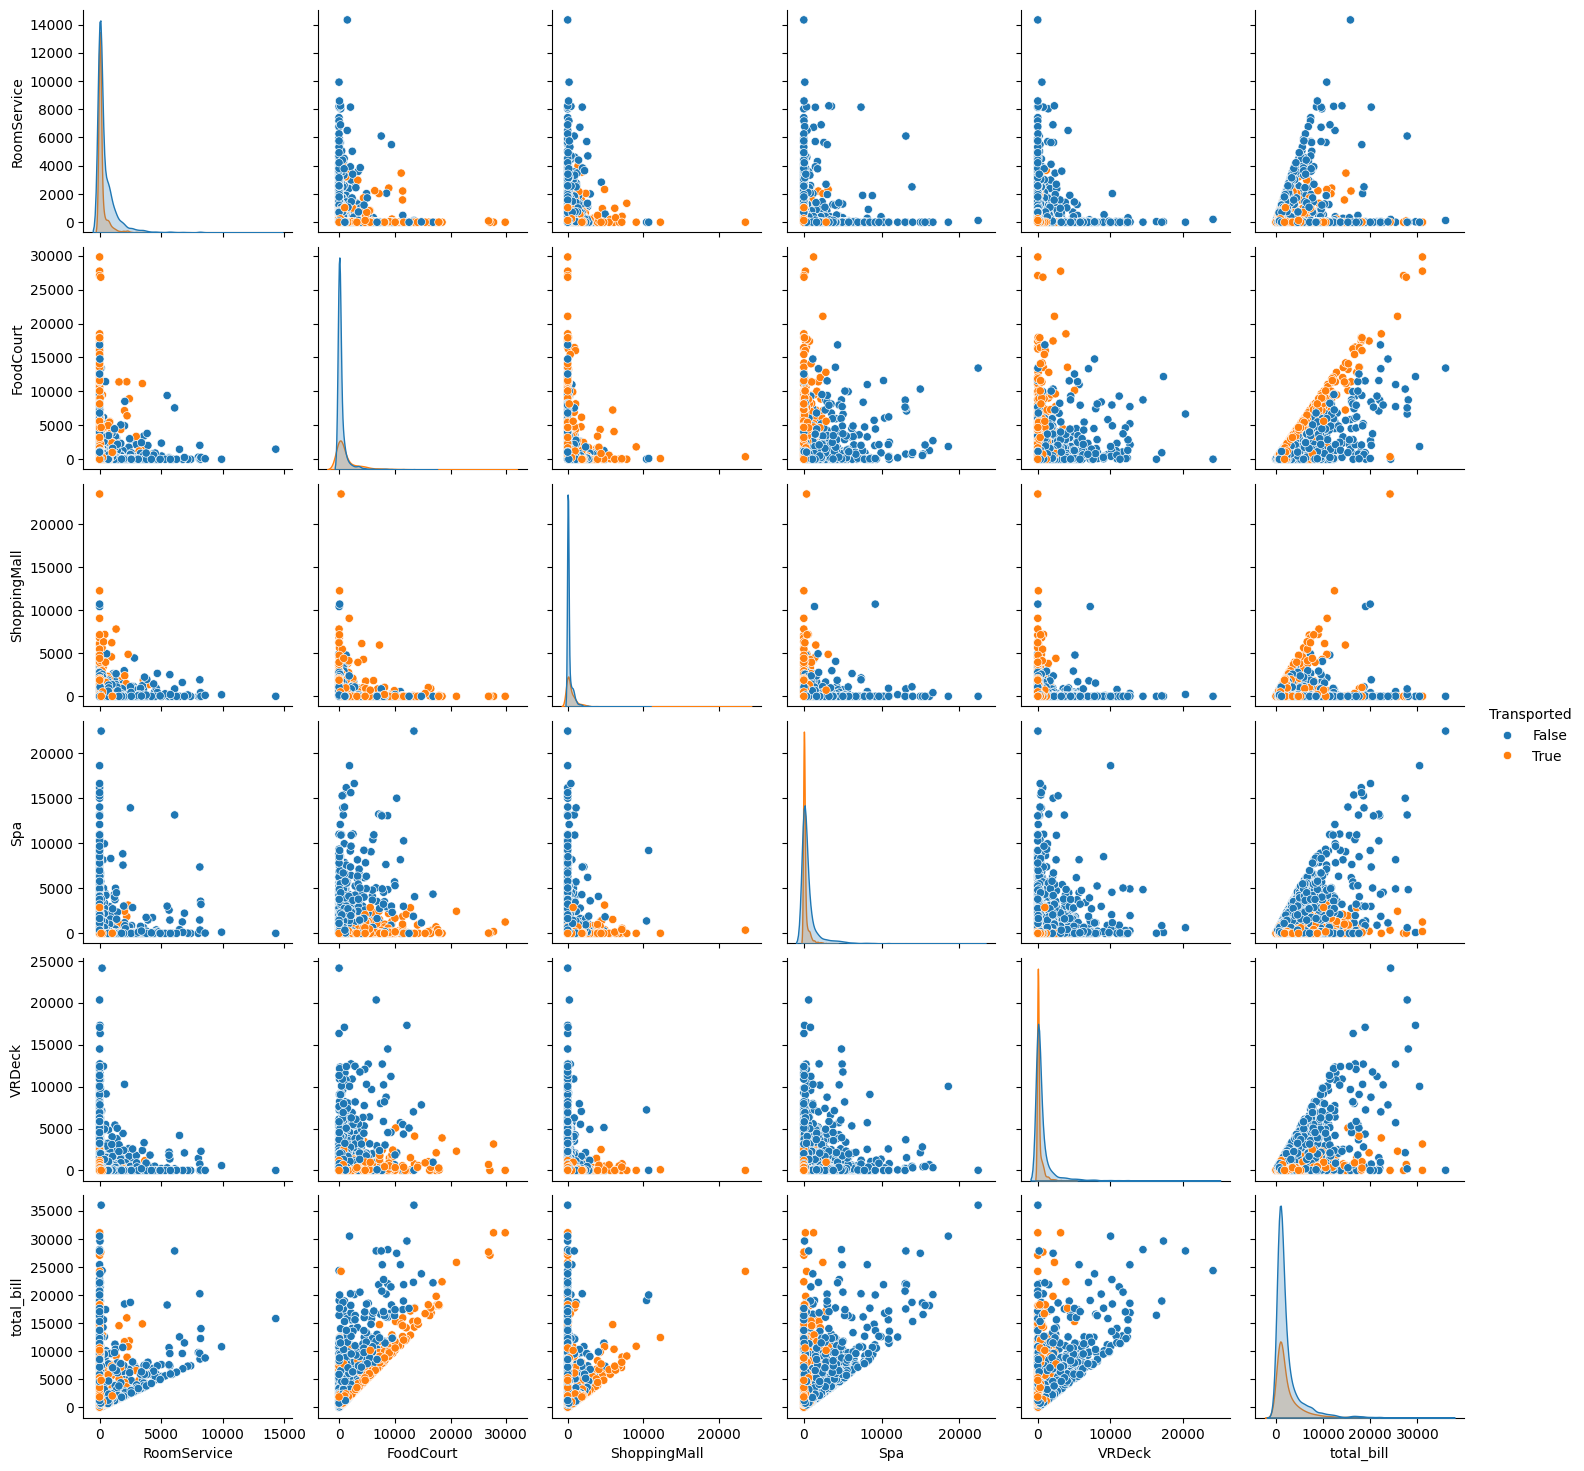

In [15]:
consumption = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']]
consumption['total_bill'] = consumption.drop('Transported', axis = 1).sum(axis = 1)
sns.pairplot(data = consumption.loc[consumption.total_bill > 0], hue = 'Transported')

In [16]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', ]].corr()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
RoomService,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,-0.019581,0.227995,-0.007322,0.153821,1.000000


<Axes: xlabel='CryoSleep', ylabel='Transported'>

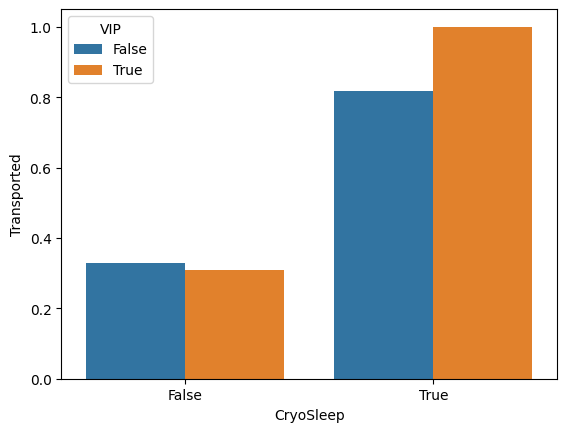

In [17]:
sns.barplot(data = df, x = 'CryoSleep', y = 'Transported', hue = 'VIP', errorbar = None)

<Axes: xlabel='VIP', ylabel='Transported'>

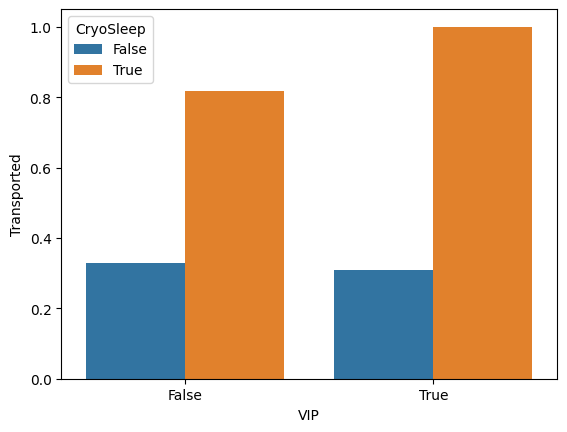

In [18]:
sns.barplot(data = df, hue = 'CryoSleep', y = 'Transported', x = 'VIP', errorbar = None)

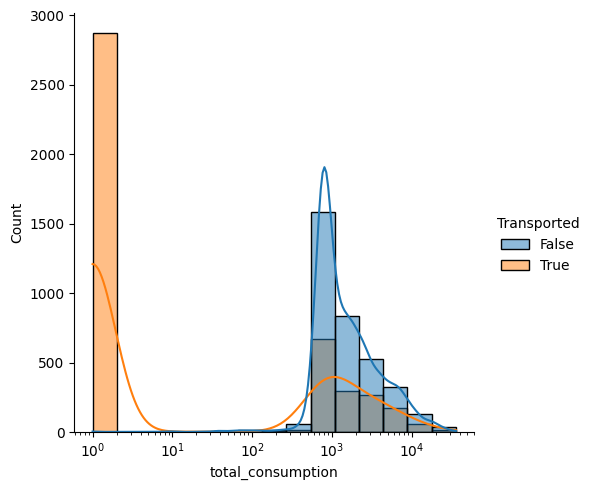

In [19]:
df['total_consumption'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']].sum(axis = 1)
sns.displot(data = df[df.total_consumption > 0], x = 'total_consumption', hue = 'Transported', kde = True, log_scale=True)

<Axes: xlabel='VIP', ylabel='Transported'>

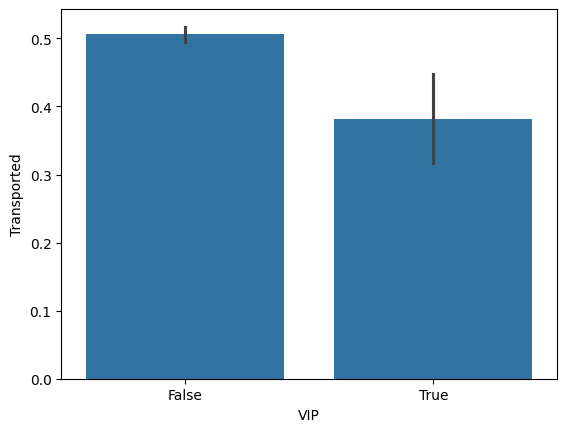

In [20]:
sns.barplot(data = df, x = 'VIP', y = 'Transported')

#### Name
Using name and passenger group, it is possible to create an indicator if people traveling in the same group are family since if so it's more likely for people to share the same last name. But this indicator doesn't seem to distinguish between size group

In [21]:
df['name_length'] = df.Name.str.split(' ').str.len()
df['first_name'] = df.Name.str.split(' ').str[0]
df['last_name'] = df.Name.str.split(' ').str[-1]

In [22]:
print('Number of people with prefix or suffix:', df[df.name_length > 2].PassengerId.count())

Number of people with prefix or suffix: 0


In [23]:
last_name_counts = df.groupby('passenger_group').last_name.nunique().reset_index().rename(columns = {'last_name': 'last_name_cnt'})
last_name_counts['family_ind'] = np.where(last_name_counts.last_name_cnt > 1, False, True)

In [24]:
df = pd.merge(df, last_name_counts[['passenger_group', 'family_ind']], 'left', on = 'passenger_group')

<Axes: xlabel='group_size', ylabel='Transported'>

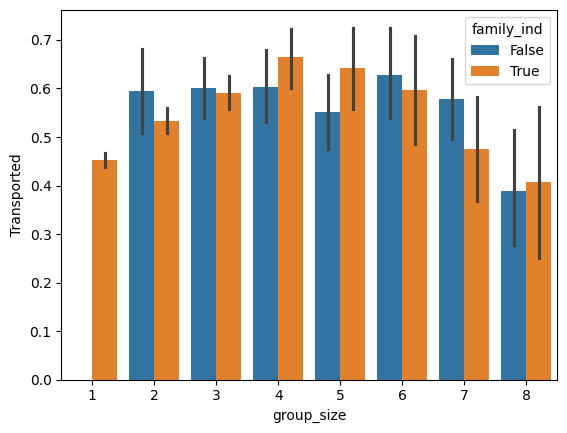

In [25]:
sns.barplot(data = df, x = 'group_size', y = 'Transported', hue = 'family_ind')

#### Clean up training data and set up pipelines for data pre-processing
- For numeric variables: use KNN imputer
- For categorical variables: most frequent imputer

In [26]:
dfc = df.drop(columns = ['Cabin', 'passenger_group', 'Name', 'first_name', 'last_name', 'name_length', 'total_consumption', 'cabin_num'])

In [27]:
dfc.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group_size,deck,side,family_ind
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,P,True
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,F,S,True
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,A,S,True
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,A,S,True
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,S,True


In [28]:
target_var = ['Transported']
id_col = ['PassengerId']
num_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'group_size']
cat_vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side', 'family_ind']

In [32]:
X_train = dfc[num_vars + cat_vars]
y_train = dfc[target_var]

In [30]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [31]:
num_pipeline = Pipeline(
    steps = [
        ('num_impute', KNNImputer()),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps = [
        ('cat_impute', SimpleImputer(strategy = 'most_frequent')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

data_preprocessing = ColumnTransformer(
    [
        ('num', num_pipeline, num_vars),
        ('cat', cat_pipeline, cat_vars)
    ]
)

### Model selection and hyperparameter tuning

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
model = Pipeline(
    steps = [
        ('data_processing', data_preprocessing),
        ('clf', None)
    ]
)

model_selection_grid = {
    'clf': [LogisticRegression(), DecisionTreeClassifier(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()]
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'auc': 'roc_auc'
}


model_selection_grid = GridSearchCV(
    model,
    param_grid = model_selection_grid,
    scoring = scoring,
    refit = 'f1'
).fit(X_train, y_train)

In [41]:
pd.DataFrame(model_selection_grid.cv_results_).sort_values(by = 'rank_test_f1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc
4,1.233979,0.089992,0.192856,0.018457,GradientBoostingClassifier(),{'clf': GradientBoostingClassifier()},0.785509,0.779758,0.801035,0.813003,0.798619,0.795585,0.011784,1,0.736570,0.720374,0.838284,0.846409,0.752381,0.778804,0.052923,3,0.858002,0.858736,0.792924,0.804622,0.859734,0.834804,0.029656,1,0.792663,0.783493,0.814973,0.824987,0.802483,0.803720,0.014912,1,0.873643,0.876123,0.887747,0.892597,0.897348,0.885492,0.009212,1
2,1.797639,0.083253,1.305382,0.049932,SVC(),{'clf': SVC()},0.780909,0.786084,0.787234,0.799770,0.803222,0.791444,0.008550,2,0.744565,0.731629,0.846424,0.871921,0.770346,0.792977,0.056050,2,0.824308,0.851301,0.751301,0.743697,0.835550,0.801232,0.044767,3,0.782410,0.786942,0.796031,0.802721,0.801624,0.793946,0.008030,2,0.866653,0.873756,0.879313,0.886302,0.888869,0.878979,0.008133,2
0,0.403628,0.043781,0.173991,0.014735,LogisticRegression(),{'clf': LogisticRegression()},0.774008,0.784359,0.797010,0.782509,0.797468,0.787071,0.009008,3,0.731992,0.729787,0.844671,0.826879,0.757313,0.778128,0.048380,4,0.831528,0.850062,0.775234,0.762605,0.845224,0.812931,0.036664,2,0.778592,0.785346,0.808464,0.793443,0.798857,0.792940,0.010391,3,0.862608,0.867522,0.884333,0.880962,0.888816,0.876848,0.010059,3
3,0.956228,0.028475,0.209582,0.013992,RandomForestClassifier(),{'clf': RandomForestClassifier()},0.768833,0.774583,0.776308,0.772152,0.786536,0.775682,0.005980,4,0.753247,0.749100,0.858396,0.869681,0.779412,0.801967,0.051859,1,0.767750,0.773234,0.712799,0.686975,0.769045,0.741961,0.035357,4,0.760429,0.760976,0.778852,0.767606,0.774194,0.768411,0.007240,4,0.852764,0.848148,0.866155,0.860172,0.859321,0.857312,0.006246,4
1,0.383597,0.022807,0.173924,0.016704,DecisionTreeClassifier(),{'clf': DecisionTreeClassifier()},0.723404,0.709028,0.728005,0.726697,0.724971,0.722421,0.006875,5,0.694878,0.666667,0.779817,0.791922,0.694537,0.725564,0.050438,5,0.750903,0.745973,0.707596,0.679622,0.753325,0.727484,0.029135,5,0.721805,0.704094,0.741953,0.731487,0.722738,0.724415,0.012491,5,0.744492,0.728238,0.744613,0.746665,0.736541,0.740110,0.006872,5


In [46]:
from scipy.stats import uniform, norm, lognorm, loguniform, expon
from random import randint

In [ ]:
model_tuning = Pipeline(
    steps = [
        ('data_processing', data_preprocessing),
        ('clf', GradientBoostingClassifier())
    ]
)

param_dist = {
    'clf__n_estimators': range(100, 1000, 50),
    'clf__learning_rate': expon(scale = 1.0),
    'clf__subsample': uniform(0.5, 0.3)
}

model_tuning_grid = RandomizedSearchCV(
    model_tuning,
    param_distributions = param_dist,
    n_iter = 10,
    cv = 5,
    scoring = scoring,
    refit = 'f1',
    random_state = 422
).fit(X_train, y_train)

In [51]:
pd.DataFrame(model_tuning_grid.cv_results_).sort_values(by = 'rank_test_accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__n_estimators,param_clf__subsample,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc
5,4.212694,0.048912,0.199869,0.014785,0.035601,750,0.547608,"{'clf__learning_rate': 0.03560063302072367, 'c...",0.787234,0.791259,0.809086,0.823936,0.800921,0.802487,0.013151,1,0.764092,0.766909,0.817016,0.835100,0.782888,0.793201,0.028170,1,0.835616,0.841324,0.800228,0.810286,0.836571,0.824805,0.016389,1,0.798255,0.802395,0.808535,0.822506,0.808840,0.808106,0.008219,1,0.875182,0.880976,0.888723,0.893272,0.895245,0.886680,0.007560,1
7,2.265087,0.009653,0.178045,0.010661,0.078515,350,0.595866,"{'clf__learning_rate': 0.07851497492458974, 'c...",0.783209,0.786659,0.807361,0.814730,0.802647,0.798921,0.012102,2,0.764581,0.764398,0.817116,0.827995,0.786638,0.792146,0.026339,2,0.823059,0.833333,0.795662,0.797714,0.834286,0.816811,0.016908,3,0.792743,0.797378,0.806246,0.812573,0.809762,0.803740,0.007509,3,0.874705,0.882706,0.886507,0.891538,0.893524,0.885796,0.006719,3
3,3.018048,0.193098,0.186164,0.012783,0.047314,450,0.629782,"{'clf__learning_rate': 0.04731446065726679, 'c...",0.779758,0.794710,0.800460,0.816456,0.800345,0.798346,0.011791,3,0.754912,0.768356,0.807916,0.824009,0.779661,0.786971,0.025449,3,0.833333,0.848174,0.792237,0.808000,0.841143,0.824577,0.021112,2,0.792187,0.806294,0.800000,0.815926,0.809236,0.804729,0.008097,2,0.873331,0.883312,0.887947,0.891035,0.894202,0.885965,0.007268,2
0,2.997548,0.054122,0.182588,0.010327,0.284032,450,0.668111,"{'clf__learning_rate': 0.2840324162226992, 'cl...",0.774583,0.778033,0.797585,0.798044,0.774453,0.784540,0.010915,4,0.756900,0.769231,0.808235,0.821078,0.762215,0.783532,0.026031,4,0.813927,0.799087,0.784247,0.765714,0.802286,0.793052,0.016627,5,0.784378,0.783875,0.796060,0.792431,0.781737,0.787696,0.005541,4,0.864583,0.867453,0.878194,0.871920,0.873058,0.871042,0.004703,4
4,1.772864,0.235874,0.210616,0.054994,0.621066,200,0.772975,"{'clf__learning_rate': 0.6210656147946128, 'cl...",0.763657,0.787234,0.792984,0.784235,0.771001,0.779822,0.010833,5,0.745512,0.771459,0.794521,0.794811,0.755627,0.772386,0.019984,5,0.805936,0.820776,0.794521,0.770286,0.805714,0.799447,0.016799,4,0.774547,0.795354,0.794521,0.782356,0.779867,0.785329,0.008245,5,0.855764,0.867661,0.867779,0.859483,0.862584,0.862654,0.004666,5
8,1.596568,0.018378,0.215119,0.027438,0.752835,200,0.726886,"{'clf__learning_rate': 0.7528346134923225, 'cl...",0.763657,0.761357,0.779183,0.775029,0.769275,0.769700,0.006703,6,0.746554,0.745474,0.795673,0.786730,0.758170,0.766520,0.020831,6,0.803653,0.799087,0.755708,0.758857,0.795429,0.782547,0.020816,6,0.774052,0.771350,0.775176,0.772542,0.776352,0.773894,0.001790,6,0.850717,0.850637,0.856570,0.851916,0.851774,0.852323,0.002187,6
2,2.127928,0.019600,0.179134,0.009940,1.151907,300,0.680368,"{'clf__learning_rate': 1.151907435675447, 'clf...",0.741806,0.743531,0.764807,0.769275,0.733602,0.750604,0.013906,7,0.724974,0.725367,0.775029,0.783493,0.715933,0.744959,0.028337,7,0.785388,0.789954,0.751142,0.748571,0.780571,0.771125,0.017636,7,0.753973,0.756284,0.762899,0.765634,0.746856,0.757129,0.006661,7,0.806794,0.823667,0.825955,0.836372,0.791344,0.816826,0.015888,7
9,2.886147,0.009062,0.182945,0.012272,1.656543,450,0.625752,"{'clf__learning_rate': 1.6565426514

In [ ]:
best_model = model_tuning_grid.best_estimator_.fit(X_train, y_train)

### Model evaluation

In [95]:
from sklearn.metrics import precision_recall_curve, roc_curve, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

In [96]:
y_probas = best_model.predict_proba(X_train)
y_pred = best_model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(np.array(y_train['Transported']), np.array(y_probas[:, 1]))

Text(0.5, 1.0, 'Precision Recall Curve for GBM')

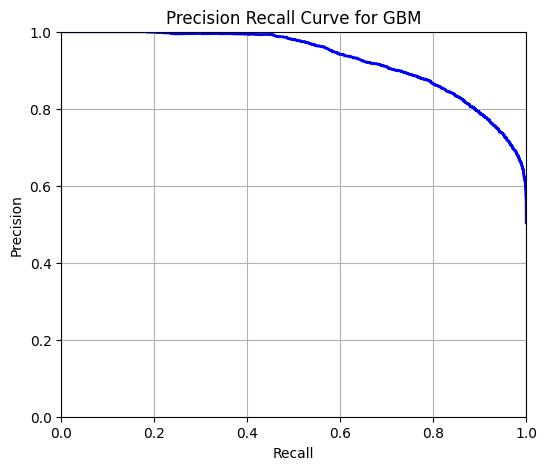

In [90]:
plt.figure(figsize=(6, 5))  
plt.plot(recalls, precisions, "b-", linewidth = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.title('Precision Recall Curve for GBM')

In [91]:
fpr, tpr, thresholds = roc_curve(np.array(y_train['Transported']), np.array(y_probas[:, 1]))

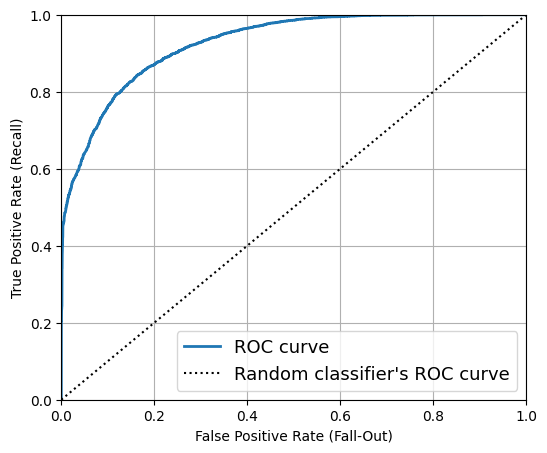

In [94]:
plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, linewidth = 2, label = "ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label = "Random classifier's ROC curve")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc = "lower right", fontsize = 13)

In [98]:
precision = precision_score(np.array(y_train['Transported']), y_pred)
recall = recall_score(np.array(y_train['Transported']), y_pred)
accuracy = accuracy_score(np.array(y_train['Transported']), y_pred)
f1 = f1_score(np.array(y_train['Transported']), y_pred)
auc = roc_auc_score(np.array(y_train['Transported']), np.array(y_probas[:, 1]))
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', auc)

Accuracy: 0.8383757045899
Precision: 0.8285082872928177
Recall: 0.8563270899954317
F1 Score: 0.8421880265079187
AUC: 0.9265220551297518


### Make predictions on test data

In [103]:
def process_test_data(df):
    
    df['passenger_group'] = df['PassengerId'].str.split('_').apply(lambda x: x[0])
    df['group_size'] = df.groupby('passenger_group').PassengerId.transform('count')
    df['deck'] = df['Cabin'].str.split('/').str[0]
    df['side'] = df['Cabin'].str.split('/').str[2]
    df['last_name'] = df.Name.str.split(' ').str[-1]
    last_name_counts = df.groupby('passenger_group').last_name.nunique().reset_index().rename(columns = {'last_name': 'last_name_cnt'})
    last_name_counts['family_ind'] = np.where(last_name_counts.last_name_cnt > 1, False, True)
    df = pd.merge(df, last_name_counts[['passenger_group', 'family_ind']], 'left', on = 'passenger_group')

    return df[['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'group_size', 'deck', 'side', 'family_ind']]

In [101]:
test = pd.read_csv('../data/spaceship_titanic/test.csv')

In [104]:
test_df = process_test_data(test)

In [105]:
id_col = ['PassengerId']
num_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'group_size']
cat_vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side', 'family_ind']
X_test = test_df[num_vars + cat_vars]

In [126]:
y_test_pred = best_model.predict(X_test)
test_pred = pd.DataFrame(pd.Series(y_test_pred, name = 'Transported'))
test_ids = test_df[id_col][['PassengerId']]
final_submission = pd.concat([test_ids, test_pred], axis = 1)
final_submission.index = final_submission['PassengerId']
final_submission = final_submission.drop(columns = 'PassengerId')

In [134]:
final_submission.to_csv('../data/spaceship_titanic/final_submission.csv')